# The vectorial schemes for hyperbolic problems

$$
\newcommand{\R}{{\mathbb R}}
\newcommand{\DdQq}[2]{{\mathrm D}_{#1}{\mathrm Q}_{#2}}
\newcommand{\drondt}{\partial_t}
\newcommand{\drondx}{\partial_x}
\newcommand{\drondy}{\partial_y}
\newcommand{\drondtt}{\partial_{tt}}
\newcommand{\drondxx}{\partial_{xx}}
\newcommand{\dx}{\Delta x}
\newcommand{\dt}{\Delta t}
\newcommand{\grandO}{{\mathcal O}}
\newcommand{\density}[2]{\,f_{#1}^{#2}}
\newcommand{\fk}[1]{\density{#1}{\vphantom{\star}}}
\newcommand{\fks}[1]{\density{#1}{\star}}
\newcommand{\moment}[2]{\,m_{#1}^{#2}}
\newcommand{\mk}[1]{\moment{#1}{\vphantom{\star}}}
\newcommand{\mke}[1]{\moment{#1}{e}}
\newcommand{\mks}[1]{\moment{#1}{\star}}
$$

Consider the conservative hyperbolic problem
$$\drondt u(t,x) + \drondx {\cdot} f(u(t,x)) = 0, \qquad t>0, \quad x\in\R^d,$$
where $u(t,x)\in\R^N$.

A vectorial scheme can be build by coupling $N$ elementary Boltzmann schemes, one for each scalar equation. The coupling takes place in the relaxation phase and in particular in the equilibrium values of the non conserved moments.

In this work session, we investigate some classical hyperbolic systems like the shallow water and the Euler systems. 

## Euler in 1D

The Euler system reads
$$\begin{aligned}&\drondt \rho + \drondx q = 0,\\ &\drondt q + \drondx \Bigl[ (\gamma-1)E + \frac{3-\gamma}{2} \frac{q^2}{\rho} \Bigr] = 0,\\ &\drondt E + \drondx \Bigl[ \gamma\frac{Eq}{\rho} - \frac{\gamma-1}{2} \frac{q^3}{\rho^2}\Bigr] = 0, \end{aligned}$$
where $\gamma=1.4$ for instance.

The solution of this system is computed by using a vectorial scheme composed by $3$ coupled $\DdQq{1}{2}$. The initial condition will be a Riemann problem to simulate the shock tube of Sod corresponding to
$$\rho_L = 1, \rho_R=\frac{1}{8}, p_L=1, p_R=\frac{1}{10}, u_L=u_R = 0,$$
with
$$q = \rho u, \quad E = \rho u^2 + \frac{p}{\gamma-1}.$$

In [1]:
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
import pyLBM

%matplotlib notebook

In [2]:
def exact_riemann_solution(q_l,q_r,x,t,gamma=1.4):
    """Return the exact solution to the Riemann problem with initial states q_l, q_r.
       The solution is computed at time t and points x (where x may be a 1D numpy array).
       
       The input vectors are the conserved quantities but the outputs are [rho,u,p].
    """
    rho_l = q_l[0]
    u_l = q_l[1]/q_l[0]
    E_l = q_l[2]
    
    rho_r = q_r[0]
    u_r = q_r[1]/q_r[0]
    E_r = q_r[2]

    # Compute left and right state pressures
    p_l = (gamma-1.)*(E_l - 0.5*rho_l*u_l**2)
    p_r = (gamma-1.)*(E_r - 0.5*rho_r*u_r**2)

    # Compute left and right state sound speeds
    c_l = np.sqrt(gamma*p_l/rho_l)
    c_r = np.sqrt(gamma*p_r/rho_r)
    
    alpha = (gamma-1.)/(2.*gamma)
    beta = (gamma+1.)/(gamma-1.)

    # Check for cavitation
    if u_l - u_r + 2*(c_l+c_r)/(gamma-1.) < 0:
        print('Cavitation detected!  Exiting.')
        return None
    
    # Define the integral curves and hugoniot loci
    integral_curve_1 = lambda p : u_l + 2*c_l/(gamma-1.)*(1.-(p/p_l)**((gamma-1.)/(2.*gamma)))
    integral_curve_3 = lambda p : u_r - 2*c_r/(gamma-1.)*(1.-(p/p_r)**((gamma-1.)/(2.*gamma)))
    hugoniot_locus_1 = lambda p : u_l + 2*c_l/np.sqrt(2*gamma*(gamma-1.)) * ((1-p/p_l)/np.sqrt(1+beta*p/p_l))
    hugoniot_locus_3 = lambda p : u_r - 2*c_r/np.sqrt(2*gamma*(gamma-1.)) * ((1-p/p_r)/np.sqrt(1+beta*p/p_r))
    
    # Check whether the 1-wave is a shock or rarefaction
    def phi_l(p):        
        if p>=p_l: 
            return hugoniot_locus_1(p)
        else: 
            return integral_curve_1(p)
    
    # Check whether the 1-wave is a shock or rarefaction
    def phi_r(p):
        if p>=p_r: 
            return hugoniot_locus_3(p)
        else: 
            return integral_curve_3(p)
        
    phi = lambda p : phi_l(p)-phi_r(p)

    # Compute middle state p, u by finding curve intersection
    p,info, ier, msg = fsolve(phi, (p_l+p_r)/2.,full_output=True,xtol=1.e-14)
    # For strong rarefactions, sometimes fsolve needs help
    if ier!=1:
        p,info, ier, msg = fsolve(phi, (p_l+p_r)/2.,full_output=True,factor=0.1,xtol=1.e-10)
        # This should not happen:
        if ier!=1: 
            print('Warning: fsolve did not converge.')
            print(msg)

    u = phi_l(p)

    
    # Find middle state densities
    if (p<=p_l):
        rho_l_star = (p/p_l)**(1.0/gamma) * rho_l
    else:
        rho_l_star = ((1.0+beta*p/p_l)/((p/p_l)+beta))*rho_l;

    if (p<=p_r):
        rho_r_star = (p/p_r)**(1.0/gamma) * rho_r
    else:
        rho_r_star = ((1.0+beta*p/p_r)/((p/p_r)+beta))*rho_r;
        
    # compute the wave speeds
    ws = np.zeros(5) 
    # The contact speed:
    ws[2] = u
    
    # Find shock and rarefaction speeds
    if p>p_l: 
        ws[0] = (rho_l*u_l - rho_l_star*u)/(rho_l - rho_l_star)
        ws[1] = ws[0]
    else:
        c_l_star = np.sqrt(gamma*p/rho_l_star)
        ws[0] = u_l - c_l
        ws[1] = u - c_l_star

    if p>p_r: 
        ws[4] = (rho_r*u_r - rho_r_star*u)/(rho_r - rho_r_star)
        ws[3] = ws[4]
    else:
        c_r_star = np.sqrt(gamma*p/rho_r_star)
        ws[3] = u+c_r_star
        ws[4] = u_r + c_r    
    

    # Compute return values

    xs = ws*t # Wave locations
        
    # Find solution inside rarefaction fans
    xi = x/t
    u1 = ((gamma-1.)*u_l + 2*(c_l + xi))/(gamma+1.)
    u3 = ((gamma-1.)*u_r - 2*(c_r - xi))/(gamma+1.)
    rho1 = (rho_l**gamma*(u1-xi)**2/(gamma*p_l))**(1./(gamma-1.))
    rho3 = (rho_r**gamma*(xi-u3)**2/(gamma*p_r))**(1./(gamma-1.))
    p1 = p_l*(rho1/rho_l)**gamma
    p3 = p_r*(rho3/rho_r)**gamma
    
    rho_out = (x<=xs[0])*rho_l + (x>xs[0])*(x<=xs[1])*rho1 + (x>xs[1])*(x<=xs[2])*rho_l_star + (x>xs[2])*(x<=xs[3])*rho_r_star + (x>xs[3])*(x<=xs[4])*rho3 + (x>xs[4])*rho_r
    u_out   = (x<=xs[0])*u_l + (x>xs[0])*(x<=xs[1])*u1 + (x>xs[1])*(x<=xs[2])*u + (x>xs[2])*(x<=xs[3])*u + (x>xs[3])*(x<=xs[4])*u3 + (x>xs[4])*u_r
    p_out   = (x<=xs[0])*p_l + (x>xs[0])*(x<=xs[1])*p1 + (x>xs[1])*(x<=xs[2])*p + (x>xs[2])*(x<=xs[3])*p + (x>xs[3])*(x<=xs[4])*p3 + (x>xs[4])*p_r
    return rho_out, u_out, p_out

In [3]:
def Riemann_pb(x, u_L, u_R):
    xm = 0.5*(xmin+xmax)
    return u_L*(x<xm) + u_R*(x>xm) + 0.5*(u_L+u_R)*(x==xm)

# parameters
rho, q, E, X, LA = sp.symbols('rho, q, E, X, LA')
# parameters
gamma = 1.4
xmin, xmax = 0., 1.
dx = 1.e-3 # spatial step
la = 3. # velocity of the scheme
rho_L, rho_R, p_L, p_R, u_L, u_R = 1., 1./8., 1., 0.1, 0., 0.
q_L = rho_L*u_L
q_R = rho_R*u_R
E_L = rho_L*u_L**2 + p_L/(gamma-1.)
E_R = rho_R*u_R**2 + p_R/(gamma-1.)
q_l, q_r = [rho_L, q_L, E_L], [rho_R, q_R, E_R]

Tf = 0.14 # final time
s_rho, s_q, s_E = 1.9, 1.5, 1.4

dico = {
    'box': {
        'x': [xmin, xmax], 
        'label':0,
    },
    'space_step': dx,
    'scheme_velocity': la,
    'schemes':[
        {
            'velocities': [1,2],
            'conserved_moments': rho,
            'polynomials': [1, X],
            'relaxation_parameters': [0, s_rho],
            'equilibrium': [rho, q],
            'init': {rho: (Riemann_pb, (rho_L, rho_R))},
        },
        {
            'velocities': [1,2],
            'conserved_moments': q,
            'polynomials': [1, X],
            'relaxation_parameters': [0, s_q],
            'equilibrium': [q, (gamma-1.)*E+0.5*(3.-gamma)*q**2/rho],
            'init': {q: (Riemann_pb, (q_L, q_R))},
        },
        {
            'velocities': [1,2],
            'conserved_moments': E,
            'polynomials': [1, X],
            'relaxation_parameters': [0, s_E],
            'equilibrium': [E, gamma*E*q/rho-0.5*(gamma-1.)*q**3/rho**2],
            'init': {E: (Riemann_pb, (E_L, E_R))},
        },
    ],
    'boundary_conditions':{
        0:{
            'method':{
                0: pyLBM.bc.Neumann,
                1: pyLBM.bc.Neumann,
                2: pyLBM.bc.Neumann
            },
            'value':None
        },
    },
    'parameters': {LA: la},
    'generator': 'numpy',
}

sol = pyLBM.Simulation(dico)

<IPython.core.display.Javascript object>


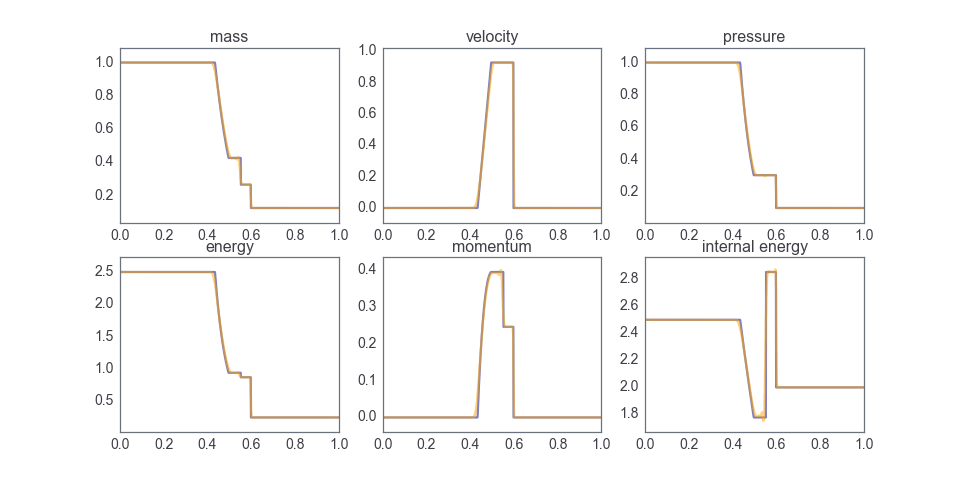

In [4]:
x = sol.domain.x
xr = x - .5*(xmin+xmax)
rho_a = sol.m[rho]
q_a = sol.m[q]
E_a = sol.m[E]
u_a = q_a/rho_a
p_a = (gamma-1.)*(E_a - .5*rho_a*u_a**2)
e_a = E_a/rho_a - .5*u_a**2

# compute the ylim values
rho_e, u_e, p_e = exact_riemann_solution(q_l, q_r, xr, .1,gamma=gamma)
q_e = rho_e*u_e
e_e = p_e/rho_e/(gamma-1.)
E_e = .5*q_e*u_e + p_e/(gamma-1.)
ymin = np.array([[min(rho_e), min(u_e), min(p_e)], [min(E_e), min(q_e), min(e_e)]])
ymax = np.array([[max(rho_e), max(u_e), max(p_e)], [max(E_e), max(q_e), max(e_e)]])
dy = .1*(ymax-ymin)
ymin -= dy
ymax += dy

viewer = pyLBM.viewer.matplotlibViewer
fig = viewer.Fig(2, 3, figsize = (12,6))

lrho_e = fig[0, 0].plot(x, rho_a, width=2, color='navy', alpha=.5)[0]
lrho_a = fig[0, 0].plot(x, rho_a, width=2, color='orange', alpha=.5)[0]
fig[0, 0].title = 'mass'
lu_e = fig[0, 1].plot(x, u_a, width=2, color='navy', alpha=.5)[0]
lu_a = fig[0, 1].plot(x, u_a, width=2, color='orange', alpha=.5)[0]
fig[0, 1].title = 'velocity'
lp_e = fig[0, 2].plot(x, p_a, width=2, color='navy', alpha=.5)[0]
lp_a = fig[0, 2].plot(x, p_a, width=2, color='orange', alpha=.5)[0]
fig[0, 2].title = 'pressure'
lE_e = fig[1, 0].plot(x, E_a, width=2, color='navy', alpha=.5)[0]
lE_a = fig[1, 0].plot(x, E_a, width=2, color='orange', alpha=.5)[0]
fig[1, 0].title = 'energy'
lq_e = fig[1, 1].plot(x, q_a, width=2, color='navy', alpha=.5)[0]
lq_a = fig[1, 1].plot(x, q_a, width=2, color='orange', alpha=.5)[0]
fig[1, 1].title = 'momentum'
le_e = fig[1, 2].plot(x, e_a, width=2, color='navy', alpha=.5)[0]
le_a = fig[1, 2].plot(x, e_a, width=2, color='orange', alpha=.5)[0]
fig[1, 2].title = 'internal energy'
for k in range(2):
    for l in range(3):
        fig[k, l].grid(False)
        fig[k, l].axis(xmin, xmax, ymin[k,l], ymax[k,l])
fig.show()

In [6]:
def update(i):
    if sol.t < Tf:
        # numerical solution
        sol.one_time_step()
        rho_a = sol.m[rho]
        q_a = sol.m[q]
        E_a = sol.m[E]
        u_a = q_a/rho_a
        p_a = (gamma-1.)*(E_a - .5*rho_a*u_a**2)
        e_a = E_a/rho_a - .5*u_a**2
        # exact solution
        rho_e, u_e, p_e = exact_riemann_solution(q_l, q_r, xr, sol.t,gamma=gamma)
        q_e = rho_e*u_e
        e_e = p_e/rho_e/(gamma-1.)
        E_e = .5*q_e*u_e + p_e/(gamma-1.)
        lrho_e.set_data(x, rho_e)
        lrho_a.set_data(x, rho_a)
        lu_e.set_data(x, u_e)
        lu_a.set_data(x, u_a)
        lp_e.set_data(x, p_e)
        lp_a.set_data(x, p_a)
        lE_e.set_data(x, E_e)
        lE_a.set_data(x, E_a)
        lq_e.set_data(x, q_e)
        lq_a.set_data(x, q_a)
        le_e.set_data(x, e_e)
        le_a.set_data(x, e_a)

# run the simulation
fig.animate(update, interval=1)
fig.show()